In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import pickle
import pathlib

In [2]:
# load data
df = pd.read_csv("eda_data.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,age,python_yn,R_yn,spark,aws,excel,job_simp,seniority,desc_len,num_comp
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,47,1,0,0,0,1,data scientist,na,2536,0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,36,1,0,0,0,0,data scientist,na,4783,0
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,10,1,0,1,0,1,data scientist,na,3461,0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,55,1,0,0,0,0,data scientist,na,3883,3
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,22,1,0,0,0,1,data scientist,na,2728,3


In [3]:
df.columns

Index(['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [4]:
# select only relevant features 
cols = [
    "avg_salary", "Rating", "age", "Industry", "job_simp", "seniority",
]
df_model = df[cols]

In [5]:
# one-hot encode categorical columns
df_dum = pd.get_dummies(df_model, drop_first=True)

In [6]:
# create X, y for training dataset
# X will hold the dataset without the avg_salary columm
X = df_dum.drop("avg_salary", axis=1)
X.head()

,Rating,age,Industry_Aerospace & Defense,Industry_Architectural & Engineering Services,Industry_Auctions & Galleries,Industry_Banks & Credit Unions,Industry_Beauty & Personal Accessories Stores,Industry_Biotech & Pharmaceuticals,Industry_Brokerage Services,Industry_Colleges & Universities,...,Industry_Video Games,Industry_Wholesale,job_simp_data engineer,job_simp_data scientist,job_simp_director,job_simp_manager,job_simp_mle,job_simp_na,seniority_na,seniority_senior
0,3.8,47,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1,3.4,36,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,4.8,10,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
3,3.8,55,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,2.9,22,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [7]:
# y will hold the dropped column
y = df_dum['avg_salary']
y

0       72.0
1       87.5
2       85.0
3       76.5
4      114.5
       ...  
685    111.5
686     84.5
687    102.5
688     73.5
689     93.5
Name: avg_salary, Length: 690, dtype: float64

In [8]:
# split into train/test datasets
# only 20% of data goes into training dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [9]:
# MAE scorer helper
pos_mae = make_scorer(mean_absolute_error, greater_is_better=False)

def cv_mae(model):
    """Return +MAE (so ‘lower is better’ is obvious)."""
    scores = cross_val_score(model, X_train, y_train, scoring=pos_mae, cv=5)
    return -scores.mean()

In [10]:
# add a 'const' column for intercept term
X_sm = X
X_sm.head()

,Rating,age,Industry_Aerospace & Defense,Industry_Architectural & Engineering Services,Industry_Auctions & Galleries,Industry_Banks & Credit Unions,Industry_Beauty & Personal Accessories Stores,Industry_Biotech & Pharmaceuticals,Industry_Brokerage Services,Industry_Colleges & Universities,...,Industry_Video Games,Industry_Wholesale,job_simp_data engineer,job_simp_data scientist,job_simp_director,job_simp_manager,job_simp_mle,job_simp_na,seniority_na,seniority_senior
0,3.8,47,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
1,3.4,36,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,4.8,10,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
3,3.8,55,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,2.9,22,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [11]:
# ─── (1) OLS for quick interpretability ──────────────────────────────────────
X_sm = sm.add_constant(X_sm.select_dtypes(include=[np.number]))
print("📊 statsmodels OLS …")
#ols_res = sm.OLS(y.astype(float), X_sm, missing='raise').fit()
ols_res = sm.OLS(y.astype(float), X_sm[['Rating', 'age']]).fit()
print(ols_res.summary())

📊 statsmodels OLS …
                                 OLS Regression Results                                
Dep. Variable:             avg_salary   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              2184.
Date:                Wed, 21 May 2025   Prob (F-statistic):                   1.03e-298
Time:                        12:27:46   Log-Likelihood:                         -3518.0
No. Observations:                 690   AIC:                                      7040.
Df Residuals:                     688   BIC:                                      7049.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

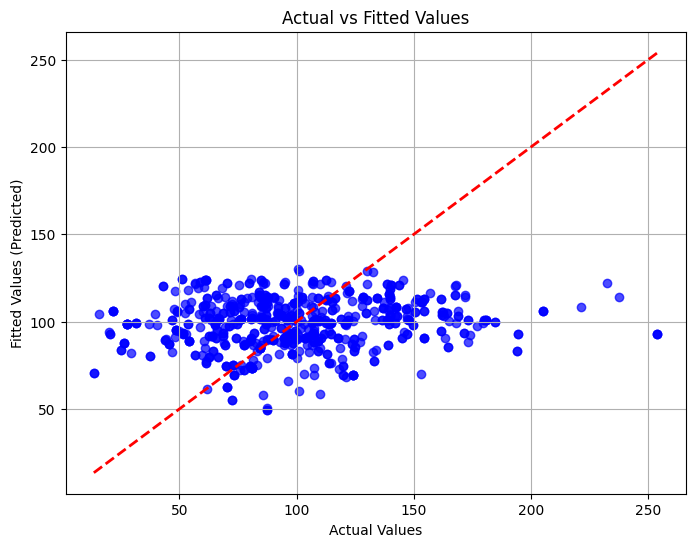

In [12]:
# Plot the fitted values against the actual data points
plt.figure(figsize=(8, 6))
plt.scatter(y, ols_res.fittedvalues, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)  # Line of perfect fit
plt.xlabel("Actual Values")
plt.ylabel("Fitted Values (Predicted)")
plt.title("Actual vs Fitted Values")
plt.grid(True)
plt.show()

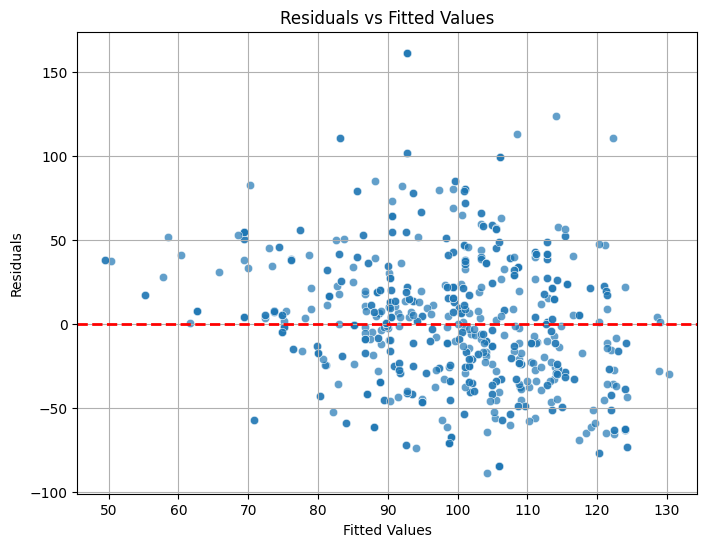

In [13]:
# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ols_res.fittedvalues, y=ols_res.resid, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(True)
plt.show()

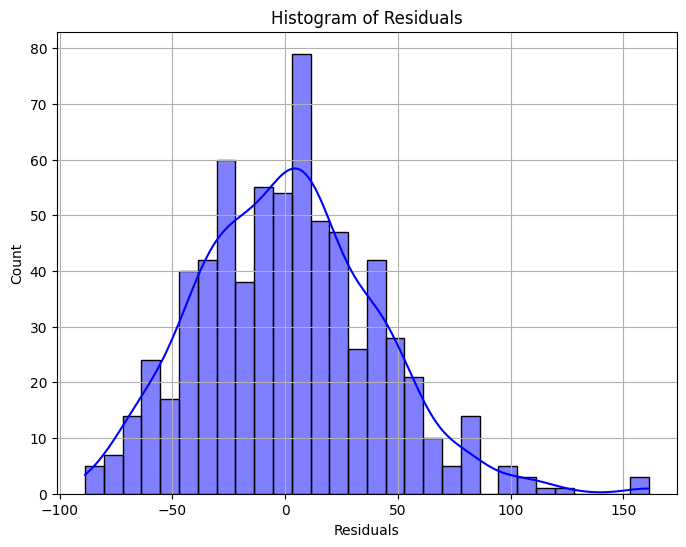

In [14]:
# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(ols_res.resid, kde=True, bins=30, color='blue')
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

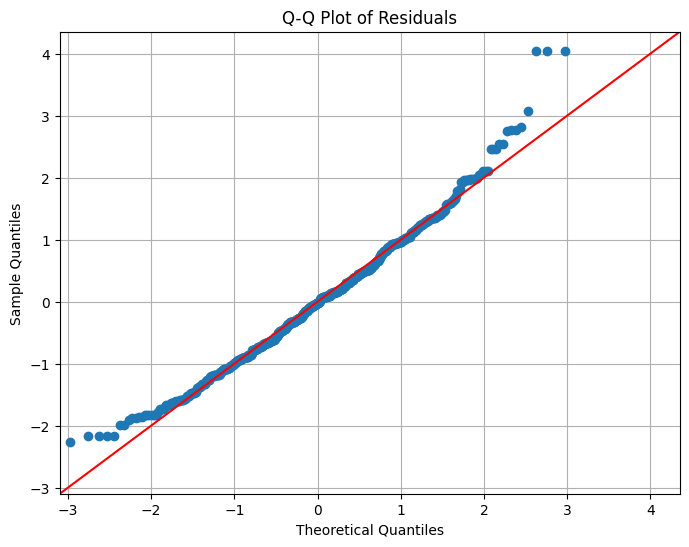

In [15]:
# Q-Q Plot of Residuals
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(ols_res.resid, line='45', fit=True, ax=ax)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

In [16]:
# ─── (2) Linear Regression ───────────────────────────────────────────────────
print("📈 Linear Regression (sklearn)…")
lm = LinearRegression()
lm_mae = cv_mae(lm)
print(f"✅ CV MAE: {lm_mae:0.2f}k USD")

📈 Linear Regression (sklearn)…
✅ CV MAE: 21.01k USD


📉 Lasso Regression …
🏆 Best alpha = 0.01 (CV MAE 21.05k)


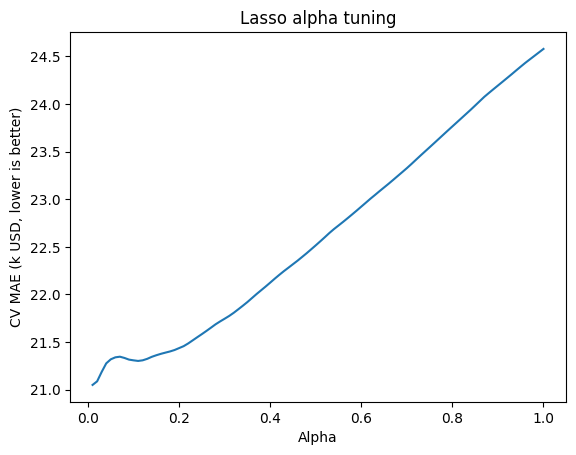

In [17]:
# ─── (3) Lasso Regression + alpha scan ───────────────────────────────────────
print("📉 Lasso Regression …")
alphas, mae_vals = [], []

for a in np.linspace(0.01, 1.0, 100):
    lml = Lasso(alpha=a, max_iter=10_000)
    mae_vals.append(cv_mae(lml))
    alphas.append(a)

best_alpha = alphas[int(np.argmin(mae_vals))]
print(f"🏆 Best alpha = {best_alpha:.2f} (CV MAE {min(mae_vals):.2f}k)")

# Plot for reference
plt.figure()
plt.plot(alphas, mae_vals)
plt.xlabel("Alpha")
plt.ylabel("CV MAE (k USD, lower is better)")
plt.title("Lasso alpha tuning")
plt.show()

In [18]:
# Re‑fit best Lasso on full training data
lasso_best = Lasso(alpha=best_alpha, max_iter=10_000).fit(X_train, y_train)


In [19]:
print("Lasso Coefficients:")
print(lasso_best.coef_.shape)
# Get the coefficients from the Lasso model
lasso_coefficients = pd.Series(lasso_best.coef_, index=X_train.columns)

# Features eliminated by Lasso (coefficients set to zero)
eliminated_features = lasso_coefficients[lasso_coefficients == 0].index.tolist()
print("Features eliminated by Lasso:")
print(eliminated_features)

# Features retained by Lasso (non-zero coefficients)
retained_features = lasso_coefficients[lasso_coefficients != 0].index.tolist()
print("\nFeatures retained by Lasso:")
print(retained_features)

Lasso Coefficients:
(65,)
Features eliminated by Lasso:
['Industry_Aerospace & Defense', 'Industry_Other Retail Stores']

Features retained by Lasso:
['Rating', 'age', 'Industry_Architectural & Engineering Services', 'Industry_Auctions & Galleries', 'Industry_Banks & Credit Unions', 'Industry_Beauty & Personal Accessories Stores', 'Industry_Biotech & Pharmaceuticals', 'Industry_Brokerage Services', 'Industry_Colleges & Universities', 'Industry_Computer Hardware & Software', 'Industry_Construction', 'Industry_Consulting', 'Industry_Consumer Product Rental', 'Industry_Consumer Products Manufacturing', 'Industry_Department, Clothing, & Shoe Stores', 'Industry_Education Training Services', 'Industry_Energy', 'Industry_Enterprise Software & Network Solutions', 'Industry_Farm Support Services', 'Industry_Federal Agencies', 'Industry_Financial Analytics & Research', 'Industry_Financial Transaction Processing', 'Industry_Food & Beverage Manufacturing', 'Industry_Gambling', 'Industry_Gas Statio

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
y_train_pred = lasso_best.predict(X_train)
y_test_pred = lasso_best.predict(X_test)

# Metrics
print("Train MSE:", mean_absolute_error(y_train, y_train_pred))
print("Test MSE:", mean_absolute_error(y_test, y_test_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

Train MSE: 18.32699138941853
Test MSE: 21.207227549840013
Train R²: 0.5481272490668869
Test R²: 0.5473881427380731


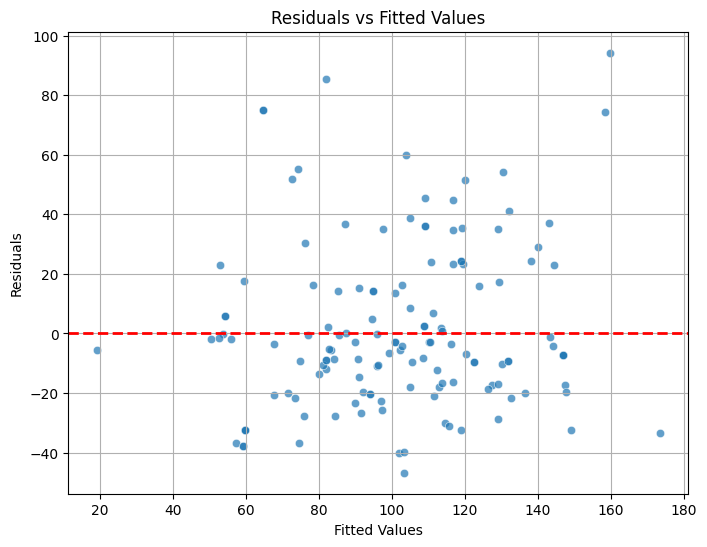

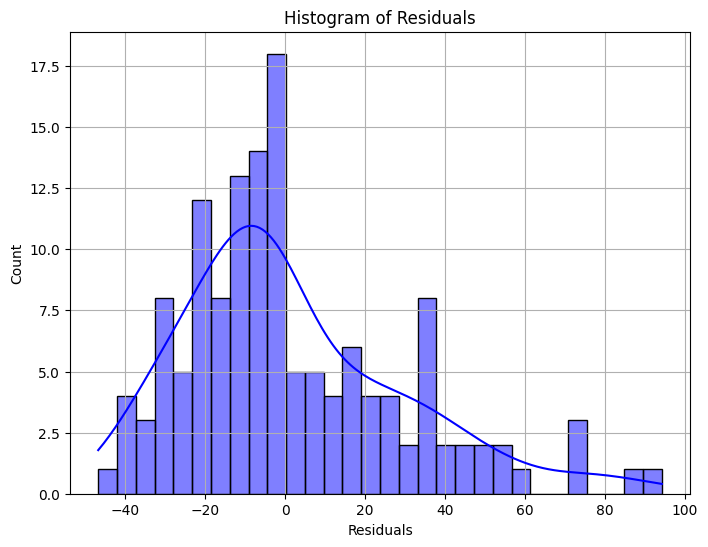

In [21]:
residuals = y_test - y_test_pred

# Residuals vs Fitted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

In [22]:
feature_importance = pd.Series(lasso_best.coef_, index=X_train.columns)
print("Feature Importance:")
print(feature_importance[feature_importance != 0].sort_values(ascending=False))

Feature Importance:
job_simp_director                                    102.408046
job_simp_mle                                          54.759728
Industry_Motion Picture Production & Distribution     44.169805
job_simp_data scientist                               43.538587
job_simp_data engineer                                35.462716
                                                        ...    
Industry_Stock Exchanges                             -26.757988
Industry_Energy                                      -28.782337
Industry_Staffing & Outsourcing                      -32.427740
Industry_Construction                                -46.759538
Industry_Financial Transaction Processing            -65.484659
Length: 63, dtype: float64


In [23]:
# Re‑fit best Lasso on full training data
lasso_best = Lasso(alpha=best_alpha, max_iter=10_000).fit(X_train, y_train)


In [24]:
# ─── (4) Random Forest + GridSearch ──────────────────────────────────────────
print("🌲 Random Forest …")
# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# Train the model on the full dataset
rf.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
sorted_features = feature_importances.sort_values(ascending=True).index.tolist()
print(sorted_features)

🌲 Random Forest …
['Industry_Other Retail Stores', 'Industry_Stock Exchanges', 'Industry_Farm Support Services', 'Industry_Mining', 'Industry_Telecommunications Manufacturing', 'Industry_Transportation Equipment Manufacturing', 'Industry_Sporting Goods Stores', 'Industry_Gas Stations', 'Industry_Transportation Management', 'Industry_Logistics & Supply Chain', 'Industry_Consumer Product Rental', 'Industry_Health Care Products Manufacturing', 'Industry_Gambling', 'Industry_Social Assistance', 'Industry_Auctions & Galleries', 'Industry_Trucking', 'Industry_Beauty & Personal Accessories Stores', 'Industry_Food & Beverage Manufacturing', 'Industry_Industrial Manufacturing', 'Industry_Banks & Credit Unions', 'Industry_TV Broadcast & Cable Networks', 'Industry_Staffing & Outsourcing', 'Industry_Wholesale', 'Industry_K-12 Education', 'Industry_Education Training Services', 'Industry_Travel Agencies', 'Industry_Financial Analytics & Research', 'Industry_Video Games', 'Industry_Telecommunication

I tried both BFE and FFC for the Random Forest Model. The FFC had better results in terms of MAE, so I am commenting out the block that does BFE.

In [25]:
# Perform Backward Feature Elimination
# best_mae = float('inf')
# best_features = X_train.columns.tolist()

# for i in range(len(sorted_features)):
#     # Remove the least important feature
#     current_features = sorted_features[i:]
#     X_train_reduced = X_train[current_features]
#     X_test_reduced = X_test[current_features]

#     # Retrain the model
#     rf.fit(X_train_reduced, y_train)
#     y_pred = rf.predict(X_test_reduced)

#     # Evaluate Performance
#     current_mae = mean_absolute_error(y_test, y_pred)
#     print(f"Features: {len(current_features)}, MAE: {current_mae:.2f}")

#     # Update best features if performance improves
#     if current_mae < best_mae:
#         best_mae = current_mae
#         best_features = current_features
#     else:
#         # stop if performance degrades
#         break

# print(f"Best Features: {best_features}")
# print(f"Best MAE: {best_mae:.2f}")

In [27]:
# Forward Feature Construction
# Start with an empty set of features
selected_features = []
remaining_features = list(X_train.columns)
best_mae = float('inf')

# Perform Forward Feature Construction
while remaining_features:
    mae_with_feature = {}
    
    # Test adding each remaining feature
    for feature in remaining_features:
        current_features = selected_features + [feature]
        X_train_subset = X_train[current_features]
        X_test_subset = X_test[current_features]
        
        # Train and evaluate the model
        rf.fit(X_train_subset, y_train)
        y_pred = rf.predict(X_test_subset)
        mae_with_feature[feature] = mean_absolute_error(y_test, y_pred)
    
    # Find the feature that gives the best improvement
    best_feature = min(mae_with_feature, key=mae_with_feature.get)
    best_feature_mae = mae_with_feature[best_feature]
    
    # Stop if performance does not improve
    if best_feature_mae < best_mae:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_mae = best_feature_mae
        print(f"Added feature: {best_feature}, MAE: {best_mae:.2f}")
    else:
        break

print(f"Selected Features: {selected_features}")
print(f"Best MAE: {best_mae:.2f}")

Added feature: job_simp_data scientist, MAE: 29.44
Added feature: age, MAE: 25.75
Added feature: Rating, MAE: 20.24
Added feature: seniority_na, MAE: 17.48
Added feature: job_simp_na, MAE: 15.73
Added feature: Industry_Enterprise Software & Network Solutions, MAE: 15.27
Added feature: Industry_Computer Hardware & Software, MAE: 14.89
Added feature: Industry_Consulting, MAE: 14.39
Added feature: Industry_Internet, MAE: 13.93
Added feature: job_simp_data engineer, MAE: 13.52
Added feature: Industry_Biotech & Pharmaceuticals, MAE: 13.18
Added feature: job_simp_mle, MAE: 12.75
Added feature: job_simp_director, MAE: 12.47
Added feature: Industry_Construction, MAE: 12.25
Added feature: Industry_Energy, MAE: 12.22
Added feature: Industry_Education Training Services, MAE: 12.12
Added feature: Industry_Motion Picture Production & Distribution, MAE: 12.04
Selected Features: ['job_simp_data scientist', 'age', 'Rating', 'seniority_na', 'job_simp_na', 'Industry_Enterprise Software & Network Solutio

In [28]:
# Retrain model with filtered features

X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]
rf.fit(X_train_filtered, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# # Assuming `selected_features` is already defined from FFC
# print(f"Using selected features: {selected_features}")

# grid = {
#     "n_estimators": range(40, 241, 40),
#     "criterion": ["squared_error", "absolute_error"],
#     "max_features": ["sqrt", "log2", None],      
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [1,2,3],
#     "min_samples_leaf": [1,2],
# }

# # Initialize GridSearchCV
# print("🔍 GridSearchCV …")
# gs = GridSearchCV(
#     rf,  # Random Forest model
#     grid,  # Parameter grid
#     scoring=pos_mae,  # Custom scoring function (negative MAE)
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available CPU cores
#     verbose=0,  # Suppress detailed output
# )

# # Fit GridSearchCV with the filtered training data
# gs.fit(X_train_filtered, y_train)

# # Get the best model and parameters
# rf_best = gs.best_estimator_
# print(f"🏆 Best RF → {rf_best}")
# print(f"✅ Best CV MAE: {-gs.best_score_:0.2f}k USD")


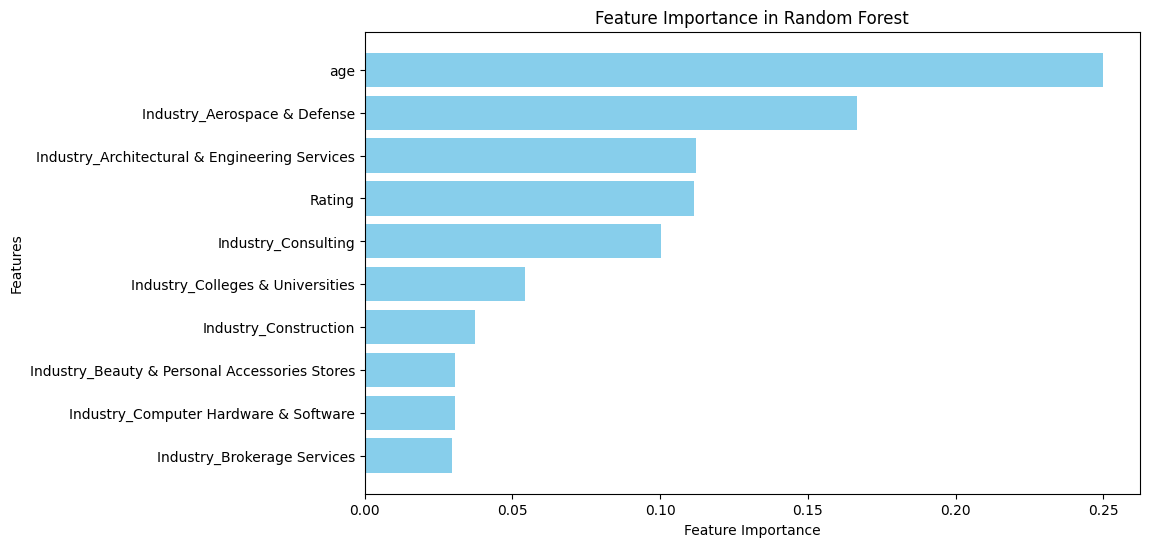

In [29]:
# Feature Importance

importances = rf.feature_importances_
features = X_train.columns
sorted_indices = importances.argsort()

# Get the top 10 features with the highest importance
top_indices = importances.argsort()[-10:]  # Select the indices of the top 10 features

# top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(features[top_indices], importances[top_indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()

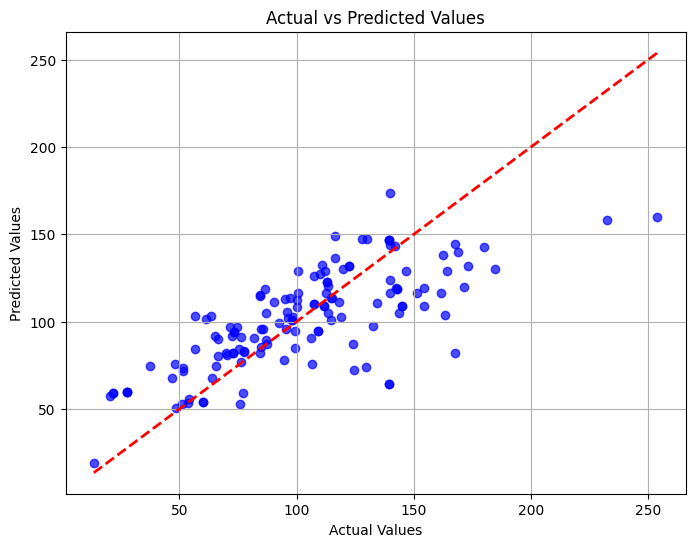

In [30]:
# Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)  # Line of perfect fit
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.show()

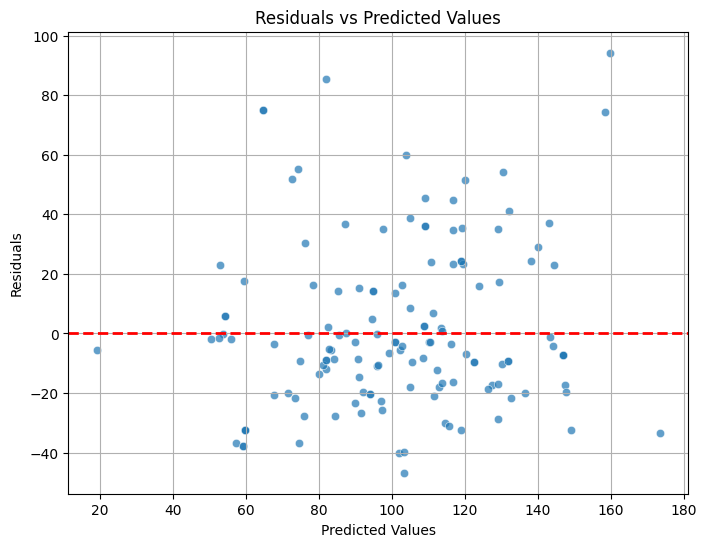

In [31]:
# Residuals vs Predicted
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.show()

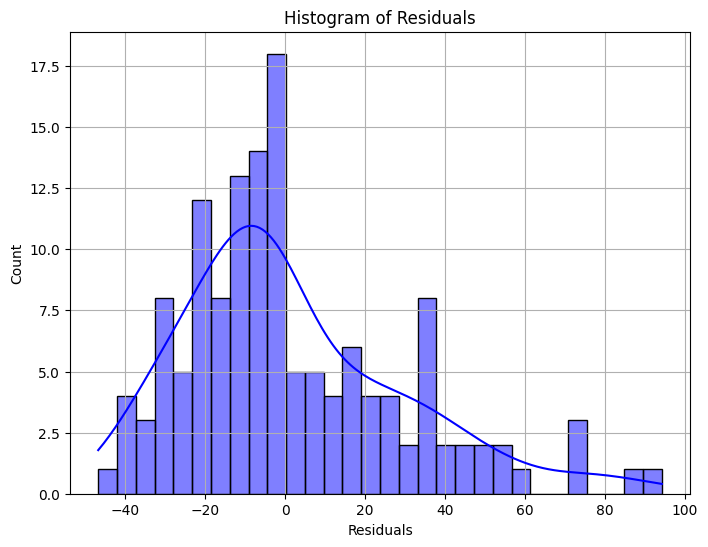

In [32]:
# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

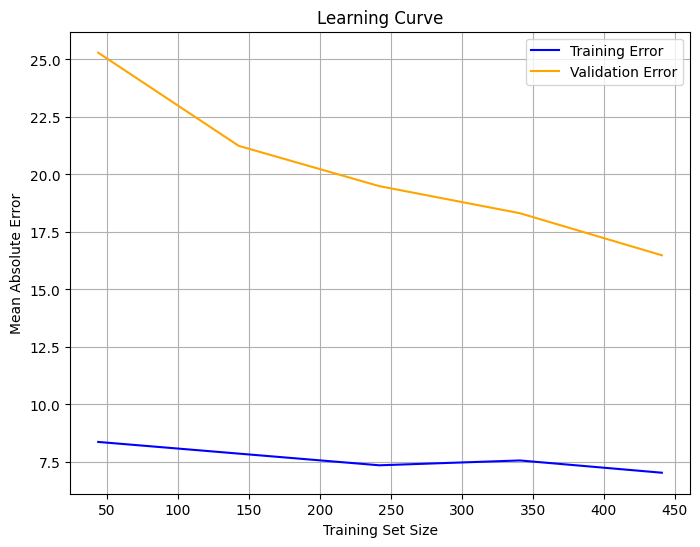

In [34]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Error", color="blue")
plt.plot(train_sizes, test_scores_mean, label="Validation Error", color="orange")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# ─── (5) Test‑set evaluation ─────────────────────────────────────────────────
print("\n🔬 Test‑set results")

for name, model, testing_set in [
    ("Linear Regression", lm.fit(X_train, y_train), X_test),
    ("Lasso",            lasso_best, X_test),
    ("Random Forest", rf, X_test_filtered)
]:
    preds = model.predict(testing_set)
    mae  = mean_absolute_error(y_test, preds)
    print(f"• {name}: MAE = {mae:0.2f}k USD")

# Simple ensemble (average of Linear & RF)
ensemble_pred = (lm.predict(X_test) + rf.predict(X_test_filtered)) / 2
ensemble_mae  = mean_absolute_error(y_test, ensemble_pred)
print(f"• Ensemble (Linear + RF): MAE = {ensemble_mae:0.2f}k USD")



🔬 Test‑set results
• Linear Regression: MAE = 21.45k USD
• Lasso: MAE = 21.21k USD
• Random Forest: MAE = 12.04k USD
• Ensemble (Linear + RF): MAE = 15.45k USD


In [53]:
# ─── (6) Persist best model ──────────────────────────────────────────────────
print("\n💾 Saving best model (Random Forest)…")
model_dir = pathlib.Path("FlaskAPI/models")
model_dir.mkdir(parents=True, exist_ok=True)

# save model and list of FFC features
model_data = {
    "model": rf,
    "features": selected_features
}

with open(model_dir / "model_file.p", "wb") as f:
    pickle.dump(model_data, f)



💾 Saving best model (Random Forest)…


In [52]:

# ─── (7) Quick sanity check ──────────────────────────────────────────────────
sample = X_test_filtered.iloc[[0]]          # keep header to avoid warning
print("\n♻️ Reloading & predicting one sample…")

with open(model_dir / "model_file.p", "rb") as f:
    model = pickle.load(f)["model"]

print("📌 Predicted salary:", model.predict(sample)[0])
print("🧾 Features used:", list(sample.iloc[0]))

print("\n✅ Pipeline finished successfully.")



♻️ Reloading & predicting one sample…
📌 Predicted salary: 109.13
🧾 Features used: [np.False_, np.int64(5), np.float64(4.4), np.True_, np.False_, np.True_, np.False_, np.False_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]

✅ Pipeline finished successfully.
